# Customer Segmentation Amazon Electronics

## Introduction

This Notebook demonstrates customer segmentation using Recency, Frequency, and Monetary (RFM) features. The data will be filtered down to only users who left reviews with verified purchases in 2022-2023, the most recently available time period in the data. 

# Setup

In [1]:
from datasets import load_dataset
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, ArrayType, BooleanType, FloatType
from pyspark import StorageLevel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

## Create a SparkSession

In [2]:
# Rename to localhost
import os
os.environ["SPARK_LOCAL_HOSTNAME"] = 'localhost'

In [3]:
# Create the SparkSession
spark = SparkSession.builder \
    .appName('customer_segmentation') \
    .config('spark.driver.memory', '16g') \
    .getOrCreate()
spark

## Load the datasets

In [4]:
# Load the Reviews data
reviews = spark.read.parquet('data/temp_reviews_parquet')

# Load the Meta data
meta = spark.read.parquet('data/temp_meta_parquet')

# Cleaning Reviews Data

In [5]:
# Add the datetime column then update the dataframe
reviews = reviews.withColumn('datetime', F.from_unixtime(F.col('timestamp') / 1000))

# Drop Images
reviews = reviews.drop('images')

# Filter data to 2022-2023 and verified purchases
reviews = reviews\
    .filter(
        (F.col('verified_purchase') == 'true') &
        (F.year('datetime').isin([2022, 2023]))
    )\
    .orderBy('datetime')

# Change ratings of 0.0 to 1.0 and update the dataframe
reviews = reviews.withColumn(
    "rating",
    F.when(F.col("rating") == 0.0, 1.0).otherwise(F.col("rating"))
)

# Change negative helpful votes to 0 and update the reviews dataframe
reviews = reviews.withColumn(
    "helpful_vote",
    F.when(F.col("helpful_vote") < 0, 0).otherwise(F.col("helpful_vote"))
)

# Drop duplicates
reviews = reviews.dropDuplicates()

# Define placeholder values that represent 'missing' data
placeholders = ['None', 'none', 'N/A', 'n/a', 'null', 'NULL', '']

# Convert any placeholder strings to null values
for c in reviews.schema.fields:
    if isinstance(c.dataType, StringType):
        reviews = reviews.withColumn(
            c.name,
            F.when(F.col(c.name).isin(placeholders), None).otherwise(F.col(c.name))
        )

In [6]:
# Print Review data Schema
reviews.printSchema()

root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- datetime: string (nullable = true)



# Cleaning Meta Data

In [7]:
# Remove the bought_together, subtitle, image, and videos columns
meta = meta.drop('bought_together', 'subtitle', 'author', 'images', 'videos')

# List of unwanted categories
unwanted_categories = [
    'Pet Supplies',
    'Toys & Games',
    'Baby',
    'Grocery',
    'Collectible Coins',
    'Automotive',
    'Handmade',
    'Health & Personal Care',
    'Arts, Crafts & Sewing',
    'All Beauty',
    'AMAZON FASHION',
    'Premium Beauty',
    'Collectibles & Fine Art',
    'Magazine Subscriptions',
    'Digital Music',
    'Tools & Home Improvement',
    'Software',
    'Unique Finds',
    'Audible Audiobooks',
    'Gift Cards',
    'Sports & Outdoors',
    'Amazon Home',
    'Books',
    'Buy a Kindle'
]

# Removing the unwanted categories
meta = meta\
    .filter(
        ~F.col('main_category').isin(unwanted_categories) 
    )
# Convert placeholders to nulls
for c in meta.schema.fields:
    if isinstance(c.dataType, StringType):
        meta = meta.withColumn(
            c.name,
            F.when(F.col(c.name).isin(placeholders), None).otherwise(F.col(c.name))
        )
# Cast the price in the meta table
meta = meta.withColumn("price", F.expr("try_cast(price AS double)"))

# Drop any duplicates
meta = meta.dropDuplicates()

In [8]:
# Print Meta data Schema
meta.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- store: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- parent_asin: string (nullable = true)



# Joining Data Tables

In [9]:
# Alias the DataFrames
r = reviews.alias('r')
m = meta.alias('m')

# Perform the left join
joined_df = r.join(
    m,
    on='parent_asin',
    how='left'
)

# Select and rename columns from the aliased DataFrames
joined_df = joined_df.select(
    *[F.col(f'r.{col}') for col in reviews.columns],
    F.col('m.main_category'),
    F.col('m.title').alias('product_name'),
    F.col('m.price'),
    F.col('m.average_rating').alias('avg_product_rating'),
    F.col('m.categories'),
    F.col('m.description'),
    F.col('m.details')
)

In [10]:
# Print Schema
joined_df.printSchema()

root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- datetime: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- avg_product_rating: double (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)



# Data Preprocessing

## Create customer_info

In [11]:
# Set a 1 year date range based on the last transaction
start_date = '2022-09-13'
end_date = '2023-09-13'

# Filter for purchases in that year
customer_info = joined_df\
    .withColumn('timestamp', F.from_unixtime((F.col('timestamp') / 1000).cast('long')).cast('timestamp'))\
    .filter(
        (F.col('timestamp') >= F.lit(start_date)) &
        (F.col('timestamp') <= F.lit(end_date))
    )\
    .select(
        'user_id',
        'timestamp',
        'price',
        'parent_asin',
    )

In [12]:
# Print Schema
customer_info.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- parent_asin: string (nullable = true)



# RFM Feature Engineering

Recency, Frequency, and Monetary (RFM) analysis is a method commonly used in marketing and analytics to segment or analyze customers. 
Traditionally, the features represent the following:

- **Recency**: how recent a customer made a purchase.
    
- **Frequency**: how often a customer makes purchases.

- **Monetary**: how much a customer spends.

We will be using RFM as the features for the model. Since we do not have customer purchase dates in the data, we will work around this by using review date as a proxy for purchase time. Because the data includes an indicator for verified purchases, we can screen whether reviewers are customers in the data. The RFM features will represent the following in this project:
- **Recency**: how recent the review left by the customer is. 
    
- **Frequency**: how often a customer leaves reviews.

- **Monetary**: how much a customer spends based on prices of the product they reviewed.

# Project Limitations

This project and its analysis is subject to the following limitations:

- Reviews aren't necessarily left at time of purchase, but often left some time after the purchase.

- Not everyone leaves a review (volunteer bias).

- Frequency does not take into account purchases of multiple quantities.

- Monetary is based on the price of the product reviewed, which may not perfectly reflect the price paid for the product. Products can change in price over time (or receive discounts), which isn't accounted for in this project. The scrape will only take into account the price of the product when it was scraped from Amazon.

- While this project uses verified customers, this pool of customers does not include all customers as not every customer leaves a review. However, analysis can still provide insights into the behavior of engaged and verified buyers, a valuable subset of the overall customer base.

In [13]:
# Set the reference date
ref_date = F.lit('2023-09-14').cast('timestamp') # The last review was left on 9/13/2023, so 9/14 was chosen as reference. 

### Find Metrics

In [14]:
# Filter out null values and instances with prices below a quarter
rfm = customer_info\
    .filter(
        (F.col("price").isNotNull()) 
        &
        (F.col('price') > 0.25)
    )

In [15]:
# Find the RFM metrics
rfm = rfm\
    .groupBy('user_id')\
    .agg(
        F.datediff(ref_date, F.max('timestamp')).alias('recency'),   # Days since last review
        F.count('parent_asin').alias('frequency'),                   # Review Frequency
        F.sum('price').alias('monetary')                             # Total spent based on price of product
    )

### Check the Skew of the RFM metrics

In [16]:
# Check the skew of the RFM metrics
rfm.select(
    F.skewness('recency').alias('recency_skew'),
    F.skewness('frequency').alias('frequency_skew'),
    F.skewness('monetary').alias('monetary_skew')
).toPandas()

,recency_skew,frequency_skew,monetary_skew
0,-0.343982,18.703403,36.024573


- Recency has a skew between -0.343982, which is acceptable since it's between -1 and 1.
- Frequency and Monetary have very high skew and need to be dealt with.
- A Log Transformation will be used to transform the data.

### Apply a log transformation to skewed features

In [17]:
# Apply a Log-Transformation to the Frequency and Monetary Features
rfm = rfm\
    .withColumn('frequency_log', F.log1p('frequency'))\
    .withColumn('monetary_log', F.log1p('monetary'))

### Scale the data

In [18]:
# Assemble features for K-Means Clustering
assembler = VectorAssembler(
    inputCols=['recency', 'frequency_log', 'monetary_log'],
    outputCol='features'
)

rfm_features = assembler.transform(rfm)

# Scale the data with Standard Scaler
scaler = StandardScaler(inputCol='features', outputCol='transformedScaledFeatures', withMean=True, withStd=True)
scalerModel = scaler.fit(rfm_features)
rfm_scaled = scalerModel.transform(rfm_features)

# Customer Segmentation with RFM

- RFM features can also be used to segment customers into groups. 
- To do this, scores need to be computed for each RFM feature.

## Compute Scores for Recency, Frequency, and Monetary features

In [19]:
# Create windows for scoring
r_window = Window.orderBy(F.col('recency').desc())    # Assign lower scores to higher recency values, and high scores to lower recency values.
f_window = Window.orderBy(F.col('frequency_log'))
m_window = Window.orderBy(F.col('monetary_log'))

# Add RFM scores
rfm_scaled = rfm_scaled\
    .withColumn('r_score', F.ntile(5).over(r_window)) \
    .withColumn('f_score', F.ntile(5).over(f_window)) \
    .withColumn('m_score', F.ntile(5).over(m_window))

- RFM Scores are computed using window functions to rank customers for each metric.
- The invididual scores for Recency, Frequency, and Monetary will then concatenated into a single combined RFM score that summarizes each customer's behavior. For example, if a customer had a recency of 1, frequency of 2, and monetary of 3, their RFM score would be 123.

## RFM Segmentation

In [20]:
# Create RFM cell using scores for each RFM feature
rfm_scores = rfm_scaled.withColumn(
    'rfm_score',
    F.concat_ws(
                '', 
                F.col('r_score').cast('string'), 
                F.col('f_score').cast('string'), 
                F.col('m_score').cast('string')
               )
)

In [21]:
# Segment based on RFM cells
rfm_scores = rfm_scores.withColumn(
    'rfm_segment',
    F.when((F.col('r_score') >= 4) & (F.col('f_score') >= 4) & (F.col('m_score') >= 4), 'Champions')
    .when((F.col('r_score') >= 3) & (F.col('f_score') >= 4) & (F.col('m_score') >= 3), 'Loyal Customers')
    .when((F.col('r_score') >= 4) & (F.col('f_score') >= 2) & (F.col('m_score') >= 2), 'Potential Loyalists')
    .when((F.col('r_score') == 5) & (F.col('f_score') <= 2) & (F.col('m_score') <= 2), 'New Customers')
    .when((F.col('r_score') >= 4) & (F.col('f_score') <= 2) & (F.col('m_score') <= 2), 'Promising')
    .when((F.col('r_score') <= 2) & (F.col('f_score') <= 2) & (F.col('m_score') >= 3), 'About to Sleep')
    .when((F.col('r_score') <= 2) & (F.col('f_score') <= 2) & (F.col('m_score') <= 2), 'Hibernating')
    .when((F.col('r_score') <= 2) & (F.col('f_score') >= 4) & (F.col('m_score') >= 4), "Can't Lose Them")
    .when((F.col('r_score') <= 2) & (F.col('f_score') >= 3) & (F.col('m_score') >= 3), 'At Risk')
    .when((F.col('r_score') <= 3) & (F.col('f_score') <= 3) & (F.col('m_score') <= 3), 'Needs Attention')
    .otherwise('Lost')
)

The customers are segmented according to their RFM scores using common labels in marketing:
- **Champions**: These are the best customers, with the most recent and frequent purchases and with the most dollar spendings.
- **Loyal Customers**: Customers who have made some less recent purchases and spend a little less than champions. But these customers have still made very recent and frequent purchases with sizeable spendings.
- **Potential Loyalists**: Customers who made recent purchases, but spent moderate amounts with moderate frequncy.
- **New customers**: Customers who made the most recent purchases, but have minimal frequency and spending.
- **Promising**: Customers who made very recent purchases but have spent have low frequency and spending.
- **About To Sleep**: Customers who have moderate spending but haven't made recent or frequenct purchases.
- **Hibernating**: Customers who haven't made a purchase in while and have spent infrequently and little. They have probably churned.
- **Can't Lose Them**: Customers who haven't made recent purchases but have previously made frequent purchases with high spendings.
- **At Risk**: Customers who haven't made recent purchases but have lower spendings and frequent purchases than those under Can't Lose Them.
- **Needs Attention**: Customers who have moderate frequency and spending, but it's been a while since they made a new purchase.
- **Lost**: Customers who have churned.

# Visualization

In [35]:
# Display sample colors of selected palette
sns.color_palette('colorblind')

# Set Seaborn Colorblind Palette
sns.set_palette('colorblind')

# Set Seaborn style to white
sns.set_style('whitegrid')

## RFM Segment Counts

In [23]:
# Select columns
selected_columns = rfm_scores.select('user_id', 'rfm_segment')

# Query the counts for each RFM segment
rfm_segment_counts = selected_columns\
    .groupBy('rfm_segment')\
    .agg(F.count('user_id').alias('count'))\
    .orderBy(F.desc('count'))\
    .toPandas()

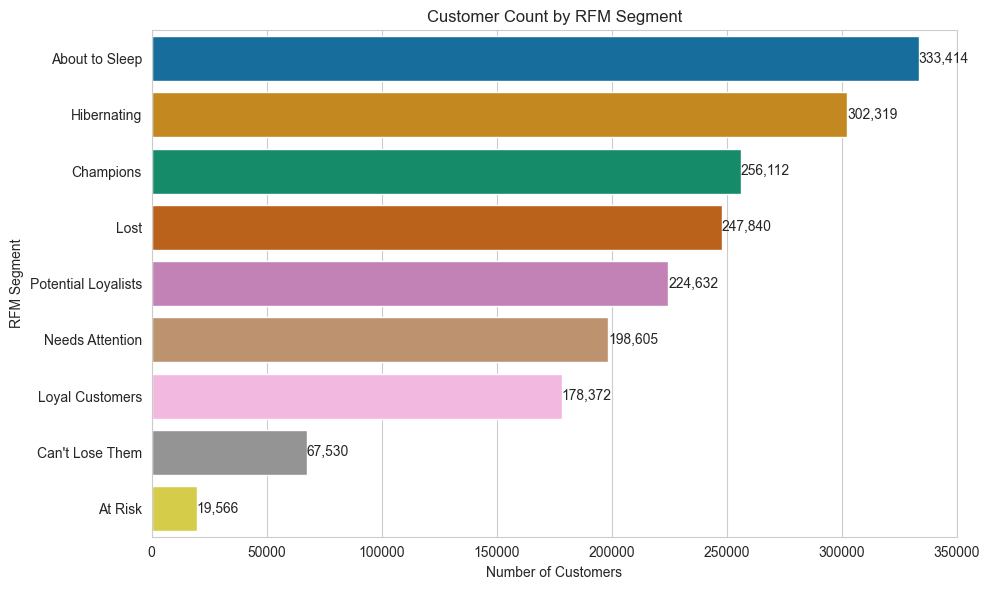

In [48]:
# Plot the horizontal barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=rfm_segment_counts, 
    y='rfm_segment', 
    x='count', 
    hue='rfm_segment', 
    orient='h'
)

# Annotate bars with counts
for p in ax.patches:
    width = p.get_width()
    ax.annotate(
        f'{int(width):,}',
        (width, p.get_y() + p.get_height() / 2), 
        ha='left', va='center',
    )

# Other settings
plt.title('Customer Count by RFM Segment')
plt.xlabel('Number of Customers')
plt.ylabel('RFM Segment')
plt.tight_layout()
plt.savefig('segmentation_visuals/rfm_segment_count')
plt.show()

- The segments with the most customers are the **About to Sleep** and **Hibernating** segments, which is bad since these customers are at risk of churn or have churned already. About to Sleep customers haven't churned yet though and may be retained through business strategy.
- The segments with the fewest customers are the **Can't Lose Them** and **At Risk** segments. This is good since a business would want those segments to be least populated.
- There don't appear to be any **New Customers** in the data. This is one of the limitations of using user reviews instead of actual customer purchase information.

## RFM Segment Pie

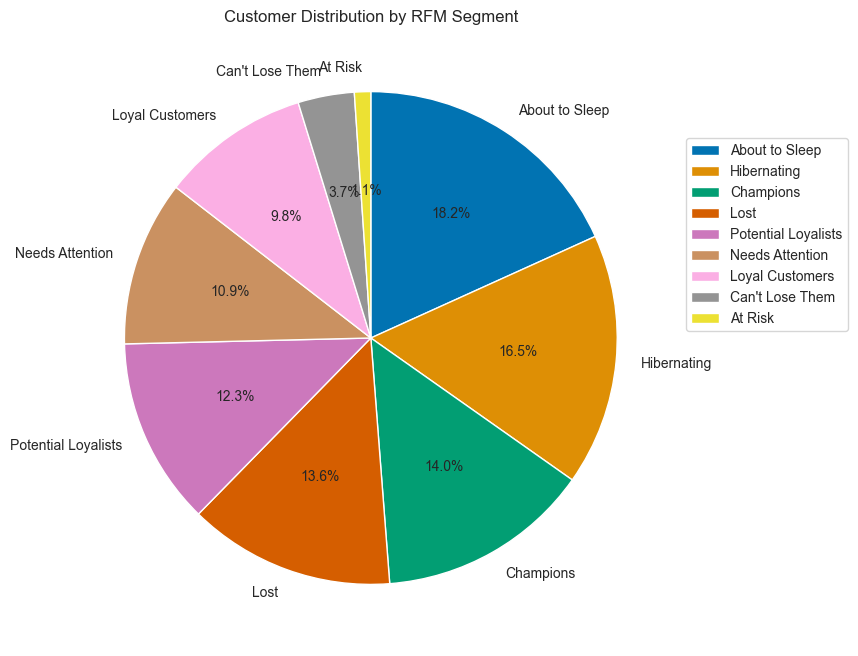

In [37]:
# Sort the data for a cleaner legend
rfm_segment_counts = rfm_segment_counts.sort_values('count', ascending=False)

# Compute percentages for each segment
rfm_segment_counts['percent'] = (
    rfm_segment_counts['count'] / rfm_segment_counts['count'].sum() * 100
)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    rfm_segment_counts['count'],
    labels=rfm_segment_counts['rfm_segment'],
    autopct='%1.1f%%',     
    startangle=90,        
    counterclock=False,   
    wedgeprops={'edgecolor': 'white'},
)

plt.title('Customer Distribution by RFM Segment')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.savefig('segmentation_visuals/rfm_segment_pie')
plt.show()

- 36% of customers are regular or high value customers (**Champions**, **Loyalists**, and **Potential Loyalists**)
- 33% of customers are at risk of churn but haven't churned yet (**About to Sleep**, **At Risk**, **Can't Lose Them**, and **Needs Attention**).
- 30% of customers have already churned (**Lost** and **Hibernating**).

## Average Monetary Value by Segment

In [26]:
# Select Recency, Monetary, and Rfm_segment columns
selected_columns = rfm_scores.select('recency', 'frequency', 'monetary', 'rfm_segment')

# Convert Spark to Pandas
rfm_and_segments = selected_columns.toPandas()

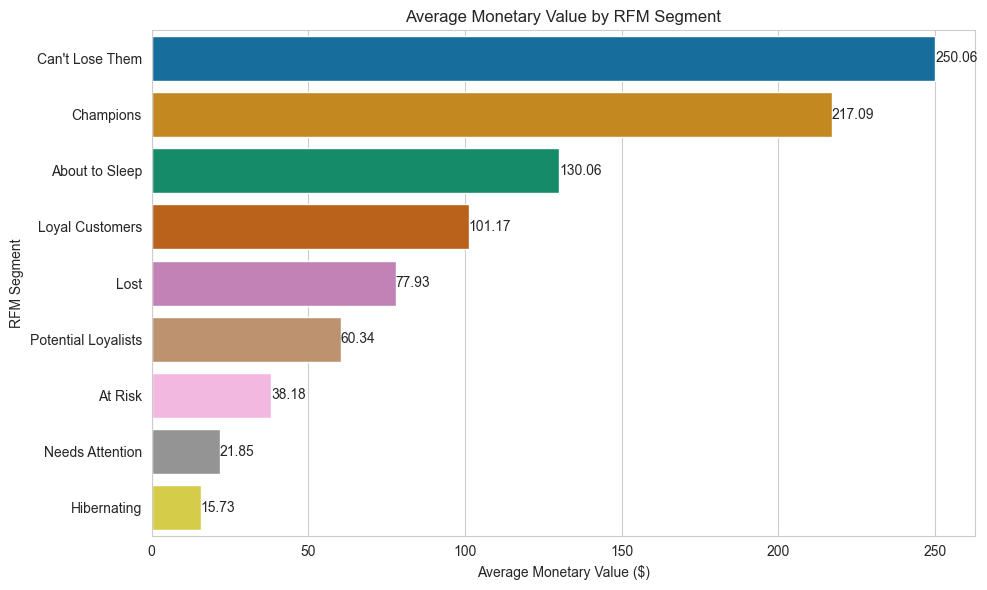

In [38]:
# Compute average monetary per segment
avg_monetary = rfm_and_segments.groupby('rfm_segment', as_index=False)['monetary'].mean()

# Sort from highest to lowest average value
avg_monetary = avg_monetary.sort_values('monetary', ascending=False) 

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=avg_monetary,
    y='rfm_segment',    
    x='monetary',
    hue='rfm_segment',  
    orient='h'        
)

# Annotate bars with average values
for p in ax.patches:
    width = p.get_width()
    ax.annotate(
        f'{width:.2f}',
        (width, p.get_y() + p.get_height() / 2),
        ha='left', va='center'
    )

plt.title('Average Monetary Value by RFM Segment')
plt.xlabel('Average Monetary Value ($)')
plt.ylabel('RFM Segment')
plt.legend([],[], frameon=False) 
plt.tight_layout()
plt.savefig('segmentation_visuals/avg_monetary_by_segment')
plt.show()

- Based on average Monetary value, customers in the **Can't Lose Them** and **About to Sleep** categories are high value customers that should be targeted for retention.
- **Hibernating**, **Needs Attention**, and **At Risk** customers have the lowest average Monetary value.

## Total Monetary Value by Segment

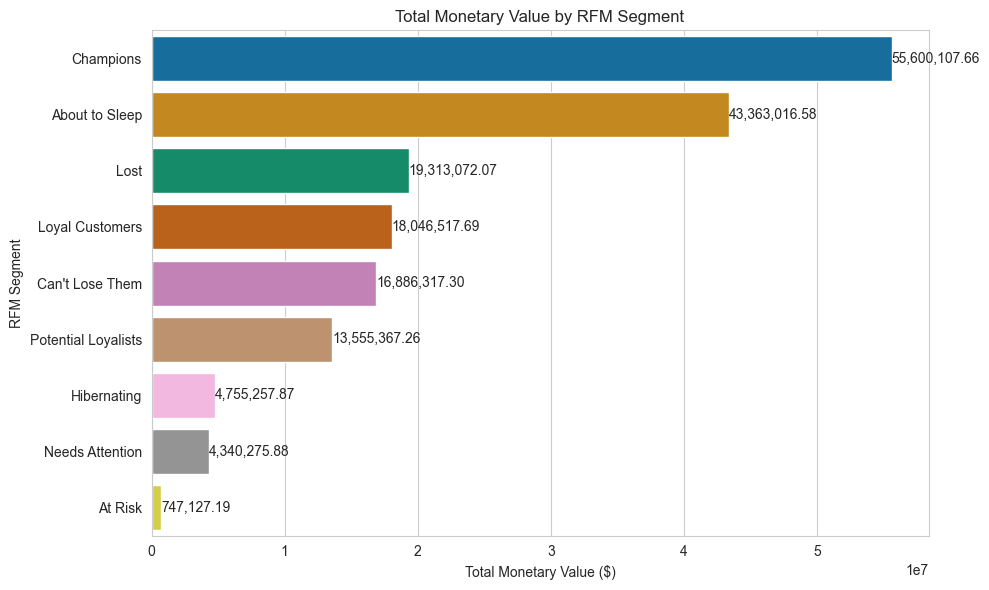

In [51]:
# Compute total monetary per segment
total_monetary = rfm_and_segments.groupby('rfm_segment', as_index=False)['monetary'].sum()

# Sort from highest to lowest total value
total_monetary = total_monetary.sort_values('monetary', ascending=False) 

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=total_monetary,
    y='rfm_segment',    
    x='monetary',
    hue='rfm_segment',  
    orient='h'        
)

# Annotate bars with total values
for p in ax.patches:
    width = p.get_width()
    ax.annotate(
        f'{width:,.2f}',
        (width, p.get_y() + p.get_height() / 2),
        ha='left', va='center'
    )

plt.title('Total Monetary Value by RFM Segment')
plt.xlabel('Total Monetary Value ($)')
plt.ylabel('RFM Segment')
plt.legend([],[], frameon=False) 
plt.tight_layout()
plt.savefig('segmentation_visuals/total_monetary_by_segment')
plt.show()

- Based on total Monetary value, customers in the **Champions** and **About to Sleep** segments contain the highest value customers.
- **Hibernating**, **Needs Attention**, and **At Risk** customers have the lowest total Monetary value.
- **Can't Lose Them** customers are notable since they have the highest average monetary value but lower total monetary value. This could mean that these customers have few members in the segment, but have high spending per member. This segment has very high value and measures should be taken to retain them.

# Insights

- **Can't Lose Them** customers should be prioritized since they have on average, high levels of spending per capita.
- **About to Sleep** customers have good spending per capita and are the second most important group among customers at risk of churning.
- **Needs Attention** and **At Risk** customers are customers at risk of churning. However, they have low levels of spending.
- 36% of customers are regular or high value customers (**Champions**, **Loyalists**, and **Potential Loyalists**)
- 33% of customers are at risk of churn but haven't churned yet (**About to Sleep**, **At Risk**, **Can't Lose Them**, and **Needs Attention**).
- 30% of customers have already churned (**Lost** and **Hibernating**).

# Recommendations for RFM Segments

- Customers in the **About to Sleep** and **Can't Lose Them** segments should be targeted with discounts and promotions. This could be done by showing discounted products in their product recommendations (on the front page) or offering these customers a 1-month trial of Amazon Prime.
- Customers categorized as **Can't Lose Them** should be focused on, since they are at risk of churning and have high levels of spending.
- Customers in the **Needs Attention** and **At Risk** segments require more careful consideration. They are at risk of churning, but have low average and total spending. The benefits of retaining them may not be worth the costs of doing so.
- Marketing campaigns should be launched to find **New Customers** and reach **Hibernating** and **Lost** customers in an attempt to rekindle interest and get them to return.
- Consider rewarding **Champions**, **Loyal Customers**, and **Potential Loyalists** for being good customers. Consider offering exclusive perks, discounts, or coupons to these customers. Or create some loyalty program based on spending, which may encourage more purchases from them.

# Close the SparkSession

In [52]:
# Stop the SparkSession
spark.stop()